In [2]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=2.0)
sns.set_style('whitegrid')

from functions import *

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

with SequenceFile("data/uniprot-9606.fasta", digital=True, alphabet=alphabet) as seq_file:
    sequences = list(seq_file)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


##### E. coli

In [4]:
### E. coli proteome 
# July 16, 2024
# https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000002032/UP000002032_469008.fasta.gz
    

ecoli = fasta_reader('data/UP000002032_469008.fasta.gz')
ecoli['Accession'] = ecoli['Accession'].str.replace(r'\|', '-', regex=True)
ecoli

,Accession,Sequence
0,tr-A0A140N2I1-A0A140N2I1_ECOBD,MKPTTLLLIFTFFAMPGIVYAESPFSSLQSAKEKTTVLQDLRKICT...
1,tr-A0A140N3Z8-A0A140N3Z8_ECOBD,MDQKLLTDFRSELLDSRFGAKAISTIAESKRFPLHEMRDDVAFQII...
2,tr-A0A140N472-A0A140N472_ECOBD,MVSRRVQALLDQLRAQGIQDEQVLNALAAVPREKFVDEAFEQKAWD...
3,tr-A0A140N4L4-A0A140N4L4_ECOBD,MNIYIGWLFKLIPLIMGLICIALGGFVLESSGQSEYFVAGHVLISL...
4,tr-A0A140N4R8-A0A140N4R8_ECOBD,MNVNSSSNRGEAILAALKTQFPGAVLDEERQTPEQVTITVKINLLP...
...,...,...
4151,tr-A0A140NH06-A0A140NH06_ECOBD,MRKITTAEALAAQIQDGATIAISGNGGGMVEADHILAAIEARFLQT...
4152,tr-A0A140NH17-A0A140NH17_ECOBD,MTELKNDRYLRALLRQPVDVTPVWMMRQAGRYLPEYKATRAQAGDF...
4153,tr-A0A140NHD7-A0A140NHD7_ECOBD,MANLLNKFIMTRILAAITLLLSIVLTILVTIFCSVPIIIAGIVKLL...
4154,tr-A0A140SS63-A0A140SS63_ECOBD,MSITKDQIIEAVAAMSVMDVVELISAMEEKFGVSAAAAVAVAAGPV...


In [6]:
ecoli.Sequence.str.len().describe()

count    4156.000000
mean      312.362368
std       209.908038
min        24.000000
25%       164.000000
50%       274.000000
75%       410.000000
max      2358.000000
Name: Sequence, dtype: float64

In [2]:
aa_known = 'ACDEFGHIKLMNPQRSTVWY'

prob_range = [0.9,]

In [22]:
for prob in prob_range:
    temp_df = ecoli.copy()

    temp_df['temp'] = temp_df.values.tolist() 
    temp_df['posteriors'] =  temp_df.temp.parallel_apply(\
                         lambda x: generate_reads(seq=x[1], aa_known=aa_known, max_prob=prob))


    temp_df['temp1'] = temp_df[['Accession', 'posteriors']].values.tolist() 
    temp_df['hmm'] = temp_df.temp1.parallel_apply(\
             lambda x: hmm_build(x[1], x[0], f'full_length_{x[0]}_{aa_known}_max_prob_{prob}'))


    hmms = np.array_split(temp_df.hmm, 10)
    hmms = [i.tolist() for i in hmms]

    results = []
    for i, v in enumerate(hmms):
        results.append(score(v, sequences, background))
    #             print(f'\t\t\t\tdone: {i}', end='\r')
    fname = f'ecoli_{aa_known}_max_prob_{prob}_del.pkl.gz'

    res_df = pd.concat(results)
    res_df.to_pickle('results/scan_results/' + fname)
    del temp_df, res_df, hmms
    ! rsync -a --delete empty/ temp/

In [5]:
aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9,]

all_files = ['results/scan_results/' + f'ecoli_{aa_known}_max_prob_{prob}_del.pkl.gz' \
             for prob in prob_range]
result_dfs = [pd.read_pickle(i) for i in all_files]
# total number of HMMS
hmms = list(range(ecoli.shape[0]))

In [6]:
### Highest scoring hits per sequence

tt = result_dfs[0].groupby(['Query', 'Accession'], \
              sort=False,)[['E-value', 'Score', ]].max()

tt = tt.loc[tt.groupby(['Query'], sort=False)['E-value'].idxmin()].reset_index()
tt

,Query,Accession,E-value,Score
0,tr-A0A140N3Z8-A0A140N3Z8_ECOBD,O95470,2.110680e-01,8.852818
1,tr-A0A140N472-A0A140N472_ECOBD,P22061,5.282700e-03,15.504219
2,tr-A0A140N4L4-A0A140N4L4_ECOBD,Q9NRX3,5.185508e-01,8.314142
3,tr-A0A140N4R8-A0A140N4R8_ECOBD,O75489,1.508055e-03,16.211222
4,tr-A0A140N558-A0A140N558_ECOBD,P04181,3.064346e-12,45.095875
...,...,...,...,...
1956,tr-A0A140NDZ3-A0A140NDZ3_ECOBD,Q8NB90,7.378790e-03,13.799156
1957,tr-A0A140NFC9-A0A140NFC9_ECOBD,O75808,4.929696e+00,6.628535
1958,tr-A0A140NH17-A0A140NH17_ECOBD,P06132,1.175715e-55,189.431000
1959,tr-A0A140SS63-A0A140SS63_ECOBD,Q96M91,2.057165e-01,11.045355


### Mouse

In [7]:
### Mouse proteome 
# July 16, 2024
# https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000589/UP000000589_10090.fasta.gz

mouse = fasta_reader('data/UP000000589_10090.fasta.gz')
mouse['Accession'] = mouse['Accession'].str.replace(r'\|', '-', regex=True)
mouse = mouse[mouse.Sequence.str.len() <= mouse.Sequence.str.len().quantile(0.99)].copy()
mouse = mouse.reset_index(drop=True)
mouse.Sequence = mouse.Sequence.str.replace('U', 'C')
mouse.Sequence.str.len().describe()

count    21393.000000
mean       506.756836
std        395.323712
min          5.000000
25%        253.000000
50%        386.000000
75%        637.000000
max       2643.000000
Name: Sequence, dtype: float64

In [8]:
aa_known = 'ACDEFGHIKLMNPQRSTVWY'

prob_range = [0.9,]

In [63]:
for prob in prob_range:
    temp_df = mouse.copy()

    temp_df['temp'] = temp_df.values.tolist() 
    temp_df['posteriors'] =  temp_df.temp.parallel_apply(\
                         lambda x: generate_reads(seq=x[1], aa_known=aa_known, max_prob=prob))


    temp_df['temp1'] = temp_df[['Accession', 'posteriors']].values.tolist() 
    temp_df['hmm'] = temp_df.temp1.parallel_apply(\
             lambda x: hmm_build(x[1], x[0], f'full_length_{x[0]}_{aa_known}_max_prob_{prob}'))


    hmms = np.array_split(temp_df.hmm, 10)
    hmms = [i.tolist() for i in hmms]

    results = []
    for i, v in enumerate(hmms):
        results.append(score(v, sequences, background))
    #             print(f'\t\t\t\tdone: {i}', end='\r')
    fname = f'mouse_{aa_known}_max_prob_{prob}_del.pkl.gz'

    res_df = pd.concat(results)
    res_df.to_pickle('results/scan_results/' + fname)
    del temp_df, res_df, hmms
    ! rsync -a --delete empty/ temp/

In [9]:
### mouse

aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9,]

all_files1 = ['results/scan_results/' + f'mouse_{aa_known}_max_prob_{prob}_del.pkl.gz' \
             for prob in prob_range]
result_dfs1 = [pd.read_pickle(i) for i in all_files1]
# total number of HMMS
hmms1 = list(range(mouse.shape[0]))

tt1 = result_dfs1[0].groupby(['Query', 'Accession'], \
              sort=False,)[['E-value', 'Score', ]].max()

tt1 = tt1.loc[tt1.groupby(['Query'], sort=False)['E-value'].idxmin()].reset_index()
tt1

,Query,Accession,E-value,Score
0,tr-A0A087WRP6-A0A087WRP6_MOUSE,Q8IZU3,4.124846e-03,15.702823
1,tr-A0A087WSS9-A0A087WSS9_MOUSE,Q8IZU3,9.227046e+00,4.557771
2,tr-A2ASU7-A2ASU7_MOUSE,Q6IEU7,3.732623e-112,377.096466
3,tr-B2RWC4-B2RWC4_MOUSE,Q5JTD7,0.000000e+00,1021.437012
4,sp-C0HKE3-H2A1D_MOUSE,P04908,5.144123e-125,419.227814
...,...,...,...,...
21076,sp-Q8C633-CABS1_MOUSE,Q96KC9,4.683836e-107,360.074097
21077,sp-Q8VG09-O5P76_MOUSE,Q8WZ92,1.225434e-200,670.008728
21078,sp-Q9CR13-FMC1_MOUSE,Q96HJ9,7.645867e-95,319.478882
21079,sp-Q9D4G2-HSF2B_MOUSE,O75031,4.134682e-269,896.980042


#### Random sequences

In [10]:
# rand_seqs = 
rnd = np.random.default_rng(12345)
rand_seqs = pd.DataFrame({'Accession': range(1000), \
                          'Sequence': [''.join(i) for i in rnd.choice(list(aa), [1000, 100])]})
rand_seqs["Accession"] = rand_seqs['Accession'].astype(str)

In [209]:
for prob in prob_range:
    temp_df = rand_seqs.copy()

    temp_df['temp'] = temp_df.values.tolist() 
    temp_df['posteriors'] =  temp_df.temp.parallel_apply(\
                         lambda x: generate_reads(seq=x[1], aa_known=aa_known, max_prob=prob))


    temp_df['temp1'] = temp_df[['Accession', 'posteriors']].values.tolist() 
    temp_df['hmm'] = temp_df.temp1.parallel_apply(\
             lambda x: hmm_build(x[1], x[0], f'full_length_{x[0]}_{aa_known}_max_prob_{prob}'))


    hmms = np.array_split(temp_df.hmm, 10)
    hmms = [i.tolist() for i in hmms]

    results = []
    for i, v in enumerate(hmms):
        results.append(score(v, sequences, background))
    #             print(f'\t\t\t\tdone: {i}', end='\r')
    fname = f'randomseqs_{aa_known}_max_prob_{prob}_del.pkl.gz'

    res_df = pd.concat(results)
    res_df.to_pickle('results/scan_results/' + fname)
    del temp_df, res_df, hmms
    ! rsync -a --delete empty/ temp/

In [11]:
aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9,]

all_files2 = ['results/scan_results/' + f'randomseqs_{aa_known}_max_prob_{prob}_del.pkl.gz' \
             for prob in prob_range]
result_dfs2 = [pd.read_pickle(i) for i in all_files2]


tt2 = result_dfs2[0].groupby(['Query', 'Accession'], \
              sort=False,)[['E-value', 'Score', ]].max()

tt2 = tt2.loc[tt2.groupby(['Query'], sort=False)['E-value'].idxmin()].reset_index()
tt2

,Query,Accession,E-value,Score
0,0,Q8IZ81,1.287050,8.410328
1,3,Q9NQ60,4.392795,6.613018
2,8,P59103,0.003699,16.589417
3,9,Q09328,0.101406,11.693560
4,10,Q8NET8,0.834523,8.883063
...,...,...,...,...
336,987,O60551,0.185429,11.066324
337,989,P11686,0.041223,13.052732
338,990,Q86XN8,5.126821,6.176327
339,996,Q8WWR9,0.273750,10.382785


#### Human

In [4]:
### human

aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9,]

all_files3 = ['results/scan_results/' + f'full_length_{aa_known}_max_prob_{prob}_del.pkl.gz' \
             for prob in prob_range]
result_dfs3 = [pd.read_pickle(i) for i in all_files3]
# total number of HMMS
uniprot = fasta_reader('data/uniprot-9606.fasta')
hmms3 = list(range(uniprot.shape[0]))

tt3 = result_dfs3[0].groupby(['Query', 'Accession'], \
              sort=False,)[['E-value', 'Score', ]].max()

tt3 = tt3.loc[tt3.groupby(['Query'], sort=False)['E-value'].idxmin()].reset_index()
tt3

,Query,Accession,E-value,Score
0,A0A087X1C5,A0A087X1C5,0.000000e+00,1783.797119
1,A0A0B4J2F0,A0A0B4J2F0,5.992934e-50,171.197708
2,A0A0B4J2F2,A0A0B4J2F2,0.000000e+00,2706.735840
3,A0A0C5B5G6,A0A0C5B5G6,2.175083e-12,48.251221
4,A0A0K2S4Q6,A0A0K2S4Q6,1.475958e-206,689.567322
...,...,...,...,...
20173,Q9Y3F1,Q9Y3F1,1.557691e-50,173.215759
20174,Q9Y6C7,Q9Y6C7,3.687431e-92,310.528137
20175,Q9Y6Z2,Q9Y6Z2,2.568420e-56,192.201050
20176,X6R8D5,X6R8D5,1.539300e-130,437.869293


In [13]:
tt['Type'] = 'E. coli'
tt1['Type'] = 'Mouse'
tt2['Type'] = 'Random'
tt3['Type'] = 'Human'

# plot_df = pd.concat([tt2, tt3])
plot_df = pd.concat([tt2, tt, tt1, tt3])
plot_df.to_pickle('results/different_organisms_and_rand_seqs.pkl.gz')

In [4]:
plot_df = pd.read_pickle('results/different_organisms_and_rand_seqs.pkl.gz')
plot_df

,Query,Accession,E-value,Score,Type
0,0,Q8IZ81,1.287050e+00,8.410328,Random
1,3,Q9NQ60,4.392795e+00,6.613018,Random
2,8,P59103,3.698874e-03,16.589417,Random
3,9,Q09328,1.014061e-01,11.693560,Random
4,10,Q8NET8,8.345228e-01,8.883063,Random
...,...,...,...,...,...
20173,Q9Y3F1,Q9Y3F1,1.557691e-50,173.215759,Human
20174,Q9Y6C7,Q9Y6C7,3.687431e-92,310.528137,Human
20175,Q9Y6Z2,Q9Y6Z2,2.568420e-56,192.201050,Human
20176,X6R8D5,X6R8D5,1.539300e-130,437.869293,Human


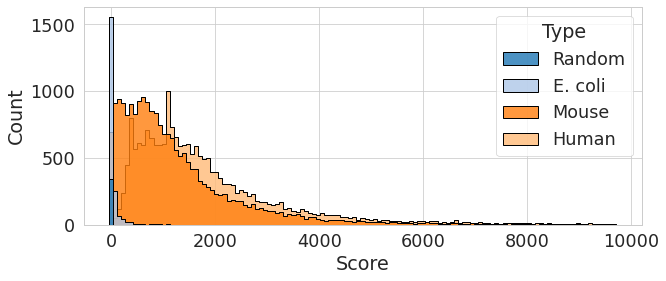

In [32]:

plt.figure(figsize=(10, 4))
ax = sns.histplot(data=plot_df, x='Score', hue='Type', palette='tab20', alpha=0.8, \
                 element='step', edgecolor='k', linewidth=1)
# ax.set_xscale('log')
# ax.set_yscale('log');

In [24]:
sns.histplot?

In [27]:
plot_df['Log E'] = np.log(plot_df['E-value'])
plot_df = plot_df.reset_index(drop=True)

/homes/bikash/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


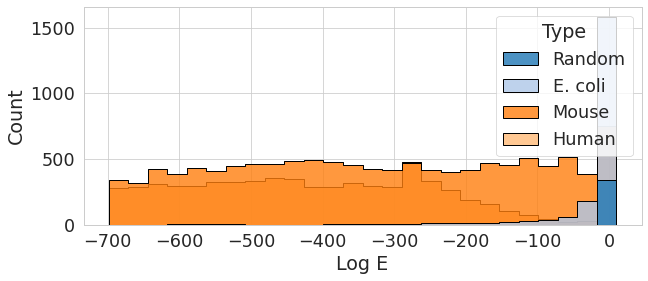

In [28]:

plt.figure(figsize=(10, 4))
ax = sns.histplot(data=plot_df, x='Log E', hue='Type', palette='tab20', alpha=0.8, \
                 element='step', edgecolor='k', linewidth=1)
# ax.set_xscale('log')
# ax.set_yscale('log');

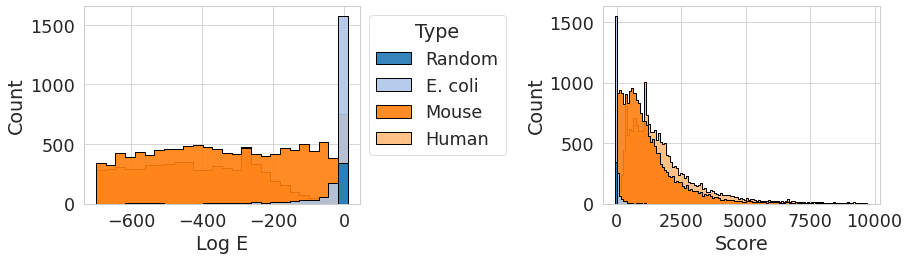

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

sns.histplot(data=plot_df, x='Score', hue='Type', palette='tab20', alpha=0.9, \
                 element='step', edgecolor='k', linewidth=1, ax=ax[1], legend=None)
sns.histplot(data=plot_df, x='Log E', hue='Type', palette='tab20', alpha=0.9, \
                 element='step', edgecolor='k', linewidth=1, ax=ax[0])
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

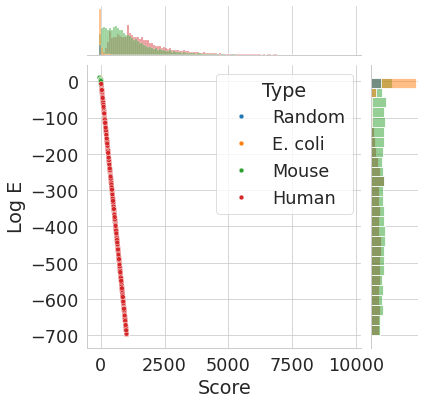

In [55]:
# sns.kdeplot(data=plot_df, x='Log E', y='Score', hue='Type', palette='tab20', )

g = sns.JointGrid(data=plot_df, y='Log E', x='Score', hue='Type', )
g.plot(sns.scatterplot, sns.histplot)

#### Human hard cases

In [3]:
db = 'data/uniprot-compressed_true_download_true_fields_accession_2Creviewed_2C-2022.10.24-11.09.16.67.tsv.gz'

uniprot_human = pd.read_csv(db, sep='\t')
uniprot_human = uniprot_human[uniprot_human.Sequence.str.len() <= uniprot_human.Sequence.str.len().quantile(0.99)].copy()
uniprot_human = uniprot_human.reset_index(drop=True)
uniprot_human.Sequence = uniprot_human.Sequence.str.replace('U', 'C')
# to merge later on 
uniprot_human = uniprot_human.rename(columns={'Entry': 'Accession'})
uniprot_human["Query"] = uniprot_human['Accession']

uniprot_human.head(2)

,Accession,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Protein families,Subcellular location [CC],PubMed ID,Sequence,Query
0,A0A087X1C5,reviewed,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),515,Cytochrome P450 family,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,15051713; 10591208; 16169517; 17494644; 18838503,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,A0A087X1C5
1,A0A0B4J2F0,reviewed,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),PIGBOS1,Homo sapiens (Human),54,NaN,SUBCELLULAR LOCATION: Mitochondrion outer memb...,14702039; 16572171; 31653868,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,A0A0B4J2F0


In [5]:
unidentified = tt3[tt3.Query != tt3.Accession].copy().reset_index(drop=True)
unidentified
# unidentified = pd.merge(unidentified, uniprot_human[['Accession', 'Protein families']])


,Query,Accession,E-value,Score
0,A6NEM1,H0YKK7,0.000000e+00,1412.562012
1,P00747,P08519,0.000000e+00,3247.004639
2,P01594,P01593,2.039307e-117,394.501068
3,P01615,A0A075B6P5,5.680957e-118,396.060211
4,P0CG47,P0CG48,0.000000e+00,2238.888916
...,...,...,...,...
188,P0DPH9,A0A1B0GTR3,9.994781e-99,332.523285
189,P0DV74,P0DV73,0.000000e+00,1543.270508
190,P0DV76,P0DV75,0.000000e+00,1542.496582
191,P86481,P86478,1.651341e-211,705.904053


In [22]:
query = pd.merge(unidentified["Query"], uniprot_human[['Query', 'Protein families', 'Length']]).reset_index(drop=True)
query.columns = ['Query', 'Query Protein families',  'Query length']

res = pd.merge(unidentified["Accession"], uniprot_human[['Accession', 'Protein families', 'Length']]).reset_index(drop=True)
res.columns = ['Accession', 'Accession Protein families',  'Accession length']

temp = pd.concat([query, res], axis=1)
temp['E-value'] = unidentified['E-value']
temp['Score'] = unidentified['Score']

## remove without any families 
no_family = temp[(temp['Query Protein families'].isna()) | (temp['Accession Protein families'].isna()) ].shape[0]
print(f'No family annotation for {no_family} sequences.')

temp = temp.dropna(axis=0).reset_index(drop=True)
temp

No family annotation for 51 sequences.


,Query,Query Protein families,Query length,Accession,Accession Protein families,Accession length,E-value,Score
0,A6NEM1,GOLGA6 family,432,H0YKK7,GOLGA6 family,550,0.000000e+00,1412.562012
1,P00747,"Peptidase S1 family, Plasminogen subfamily",810,H0YKK7,GOLGA6 family,550,0.000000e+00,3247.004639
2,P0DMN0,Sulfotransferase 1 family,295,P0CG48,Ubiquitin family,685,0.000000e+00,1048.178223
3,P0DMV9,Heat shock protein 70 family,641,P0CG48,Ubiquitin family,685,0.000000e+00,2224.539307
4,P0DP24,Calmodulin family,149,P0CG48,Ubiquitin family,685,1.367828e-146,491.011169
...,...,...,...,...,...,...,...,...
137,Q86XG9,NBPF family,351,Q9UQL6,"Histone deacetylase family, HD type 2 subfamily",1122,0.000000e+00,1183.824951
138,A0A0B4J1W7,NPIP family,369,A6NNC1,POM121 family,897,0.000000e+00,1710.463989
139,A0A1B0GV22,FAM236 family,79,Q8N972,Krueppel C2H2-type zinc-finger protein family,641,1.136720e-78,265.972198
140,P0DV76,FAM90 family,464,P0DV73,FAM90 family,464,0.000000e+00,1542.496582


In [25]:
# 193 - 24 - 51

In [7]:
(temp['Query Protein families'] == temp['Accession Protein families']).value_counts()

False    118
True      24
dtype: int64

In [166]:
temp[temp['Query Protein families'] != temp['Accession Protein families']]['Query Protein families'].value_counts()


Krueppel C2H2-type zinc-finger protein family                 25
Speedy/Ringo family                                           10
NPIP family                                                    9
NBPF family                                                    9
RRM DAZ family                                                 4
POTE family                                                    4
CT45 family                                                    4
PRR20 family                                                   4
VCX/VCY family                                                 3
GAGE family                                                    3
KRTAP type 4 family                                            2
KRTAP type 5 family                                            2
G-protein coupled receptor 1 family, Opsin subfamily           2
Immunoglobulin superfamily, CEA family                         2
Glycosyl hydrolase 13 family                                   2
Calmodulin family        

In [167]:
temp[temp['Query Protein families'] != temp['Accession Protein families']]['Accession Protein families'].value_counts()


Krueppel C2H2-type zinc-finger protein family           31
NPIP family                                             13
NBPF family                                              8
Speedy/Ringo family                                      6
Ubiquitin family                                         4
PRR20 family                                             4
POTE family                                              3
VCX/VCY family                                           3
GAGE family                                              3
CT45 family                                              3
POTE family; Actin family                                2
G-protein coupled receptor 1 family, Opsin subfamily     2
FAM25 family                                             2
KRTAP type 5 family                                      2
RRM DAZ family                                           2
Immunoglobulin superfamily, CEA family                   2
Glycosyl hydrolase 13 family                            

In [157]:
xx = temp[temp['Accession Protein families'] != temp['Query Protein families']]
xx.shape

(118, 8)

In [164]:
 xx[xx['Query Protein families'] == 'Krueppel C2H2-type zinc-finger protein family']

,Query,Query Protein families,Query length,Accession,Accession Protein families,Accession length,E-value,Score
10,P35789,Krueppel C2H2-type zinc-finger protein family,620,P0DP23,Calmodulin family,149,0.000000e+00,2370.897461
13,P52744,Krueppel C2H2-type zinc-finger protein family,262,P0DTE7,Glycosyl hydrolase 13 family,511,0.000000e+00,1645.724121
31,Q96I27,Krueppel C2H2-type zinc-finger protein family,306,P86478,PRR20 family,221,0.000000e+00,1054.721680
53,Q68DY1,Krueppel C2H2-type zinc-finger protein family,528,Q9NQZ3,RRM DAZ family,744,0.000000e+00,2391.806396
67,A8MXY4,Krueppel C2H2-type zinc-finger protein family,864,Q6L8H1,KRTAP type 5 family,288,0.000000e+00,3533.484863
69,P0CB33,Krueppel C2H2-type zinc-finger protein family,412,A6QL64,ANKRD36 family,1915,0.000000e+00,2143.114990
76,Q03924,Krueppel C2H2-type zinc-finger protein family,483,B3EWG3,FAM25 family,89,0.000000e+00,2030.302002
78,Q5VIY5,Krueppel C2H2-type zinc-finger protein family,522,P0CG34,Thymosin beta family,45,0.000000e+00,1978.648804
81,Q6ZRF7,Krueppel C2H2-type zinc-finger protein family,136,P0DP73,Beta-defensin family,79,9.085092e-183,610.265930
83,Q8IYN0,Krueppel C2H2-type zinc-finger protein family,542,P86790,CCZ1 family,482,0.000000e+00,2348.533447


#### Repeat containing proteins

In [26]:
repeats = uniprot_human[uniprot_human['Protein names'].apply(lambda x: 'repeat' in str(x).lower())]
repeats.shape

(701, 12)

In [27]:
repeat_results = pd.merge(tt3, repeats[['Protein families', 'Query']]\
        ,on='Query')

In [28]:
repeat_results[repeat_results['Query'] == repeat_results['Accession']]

,Query,Accession,E-value,Score,Protein families
0,A0AVF1,A0AVF1,0.000000e+00,1958.872437,IFT56 family
1,A4D1P6,A4D1P6,0.000000e+00,2653.656250,WD repeat WDR91 family
2,C9JR72,C9JR72,0.000000e+00,1535.088257,NaN
3,O00192,O00192,0.000000e+00,3270.446045,Beta-catenin family
4,O14593,O14593,4.910536e-265,883.195923,NaN
...,...,...,...,...,...
696,Q9ULI1,Q9ULI1,0.000000e+00,6219.935059,NaN
697,Q9Y546,Q9Y546,0.000000e+00,1499.684326,LRRC42 family
698,A6NJI9,A6NJI9,4.713710e-303,1009.270325,NaN
699,A8MYJ7,A8MYJ7,0.000000e+00,1828.972290,NaN


<AxesSubplot:>

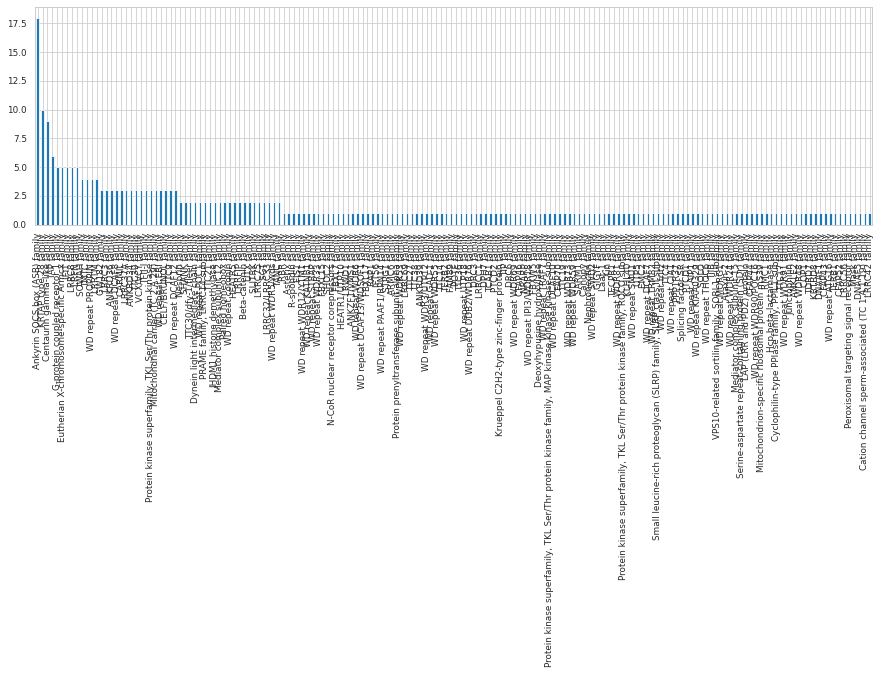

In [29]:
sns.set_context("paper", font_scale=1.0)
sns.set_style('whitegrid')
repeat_results['Protein families'].value_counts().plot(kind='bar', figsize=(15, 4))

In [30]:
repeat_results['Protein families'].value_counts()

Ankyrin SOCS box (ASB) family                           18
KRTAP type 28 family                                    10
Centaurin gamma-like family                              9
IAP family                                               6
G-protein coupled receptor 1 family                      5
                                                        ..
Peroxisomal targeting signal receptor family             1
Mask family                                              1
DNAAF5 family                                            1
Cation channel sperm-associated (TC 1.A.1.19) family     1
LRRC42 family                                            1
Name: Protein families, Length: 170, dtype: int64

In [31]:
repeat_results[repeat_results['Protein families'] == 'G-protein coupled receptor 1 family']

,Query,Accession,E-value,Score,Protein families
28,O75473,O75473,0.0,3129.020508,G-protein coupled receptor 1 family
230,Q8WXD0,Q8WXD0,0.0,2649.378662,G-protein coupled receptor 1 family
299,Q9BXB1,Q9BXB1,0.0,3312.482422,G-protein coupled receptor 1 family
328,Q9HBX8,Q9HBX8,0.0,3308.607666,G-protein coupled receptor 1 family
329,Q9HBX9,Q9HBX9,0.0,2694.754150,G-protein coupled receptor 1 family


In [ ]:
# 2021.11